In [1]:
import pandas as pd
from tensorflow import keras
from src.ParticleNet.PointNet import PointNetLayer
from src.ParticleNet.GlobalPooling import GlobalAveragePoolingLayer
from src.Preprocessing.JetPreprocessing import JetProcessingParticleCloud
from src.Preprocessing.LabelsGeneration import create_jet_labels_one_column_per_category
from sklearn.utils import shuffle
from utilities import utilities

#### Loading the Data

In [2]:
jet_preprocessing = JetProcessingParticleCloud()

# trainning 
data_gluon_train = pd.read_csv('../../Data/Trainning/g_jets.csv', header=None)
data_quark_train = pd.read_csv('../../Data/Trainning/q_jets.csv', header=None)
all_jets_train = pd.concat([data_quark_train, data_gluon_train], axis=0)
all_jets_train.reset_index(drop=True, inplace=True)

X_train = jet_preprocessing.transform(all_jets_train.to_numpy())
y_train = create_jet_labels_one_column_per_category([(0, data_quark_train.shape[0] - 1), (data_quark_train.shape[0], all_jets_train.shape[0] - 1)])

X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [3]:
# validation
data_gluon_val = pd.read_csv('../../Data/Validation/g_jets.csv', header=None)
data_quark_val = pd.read_csv('../../Data/Validation/q_jets.csv', header=None)
all_jets_val = pd.concat([data_quark_val, data_gluon_val], axis=0)
all_jets_val.reset_index(drop=True, inplace=True)

X_val = jet_preprocessing.transform(all_jets_val.to_numpy())
y_val = create_jet_labels_one_column_per_category([(0, data_quark_val.shape[0] - 1), (data_quark_val.shape[0], all_jets_val.shape[0] - 1)])

X_val, y_val = shuffle(X_val, y_val, random_state=0)

In [4]:
print(f"Size of the Training set: {len(X_train)}")
print(f"Size of the Validation set: {len(X_val)}")

Size of the Training set: 251379
Size of the Validation set: 44362


In [6]:
# first we need the MLP
mlp_jets = keras.Sequential([
    keras.layers.InputLayer(shape=[4]),
    keras.layers.Dense(32),
    # keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(32),
    # keras.layers.BatchNormalization(),
    keras.layers.ReLU()
])

mlp_jets2 = keras.Sequential([
    keras.layers.InputLayer(shape=[32]),
    keras.layers.Dense(64),
    # keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(64),
    # keras.layers.BatchNormalization(),
    keras.layers.ReLU()
])

jet_tag_model = keras.Sequential([
    keras.layers.InputLayer(shape=(30, 5)),
    PointNetLayer(mlp=mlp_jets, output_dim=32),
    PointNetLayer(mlp=mlp_jets2, output_dim=64),
    GlobalAveragePoolingLayer(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(rate=0.05),
    keras.layers.Dense(2, activation='softmax')
])

jet_tag_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ point_net_layer (PointNetLayer) │ (None, 30, 33)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ point_net_layer_1               │ (None, 30, 65)         │         6,272 │
│ (PointNetLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 64)             │             0 │
│ (GlobalAveragePoolingLayer)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,066 (62.76 KB)

 Trainable params: 16,066 (62.76 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
jet_tag_model.compile(optimizer='adam', loss='crossentropy', metrics=['accuracy'])

In [8]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = jet_tag_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])   

Epoch 1/100
7856/7856 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7321 - loss: 0.5306 - val_accuracy: 0.7498 - val_loss: 0.5080
Epoch 2/100
7856/7856 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7555 - loss: 0.5029 - val_accuracy: 0.7645 - val_loss: 0.4885
Epoch 3/100
7856/7856 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7632 - loss: 0.4929 - val_accuracy: 0.7596 - val_loss: 0.4953
Epoch 4/100
7856/7856 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7643 - loss: 0.4926 - val_accuracy: 0.7689 - val_loss: 0.4829
Epoch 5/100
7856/7856 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7715 - loss: 0.4831 - val_accuracy: 0.7739 - val_loss: 0.4746
Epoch 6/100
7856/7856 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7726 - loss: 0.4770 - val_accuracy: 0.7795 - val_loss: 0.4759
Epoch 7/100
7856/7856 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7752 - loss: 0.4738 - val_accuracy: 0.7676 - val_loss: 0.4921
Epoch 8/100
7856/7856 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7754 -

In [9]:
# perfoming the prediction
y_train_pred = jet_tag_model.predict(X_train)
y_val_pred = jet_tag_model.predict(X_val)

7856/7856 ━━━━━━━━━━━━━━━━━━━━ 6s 777us/step
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step


In [10]:
print("Trainnig set:")
utilities.display_metrics(y_true=y_train[:, 0], y_pred=y_train_pred[:, 0] > 0.5)
print("Validation set:")
utilities.display_metrics(y_true=y_val[:, 0], y_pred=y_val_pred[:, 0] > 0.5)

Trainnig set:
Recall: 0.7612
Precision: 0.8104
Confusion Matrix:
[[106099  21965]
 [ 29453  93862]]
Validation set:
Recall: 0.7599
Precision: 0.8101
Confusion Matrix:
[[18723  3877]
 [ 5226 16536]]


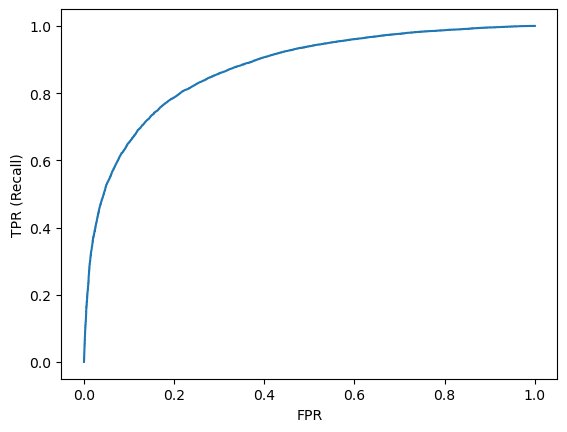

AUC: 0.8734


In [11]:
utilities.display_roc_curve(y_true=y_val[:, 0], y_score=y_val_pred[:, 0])

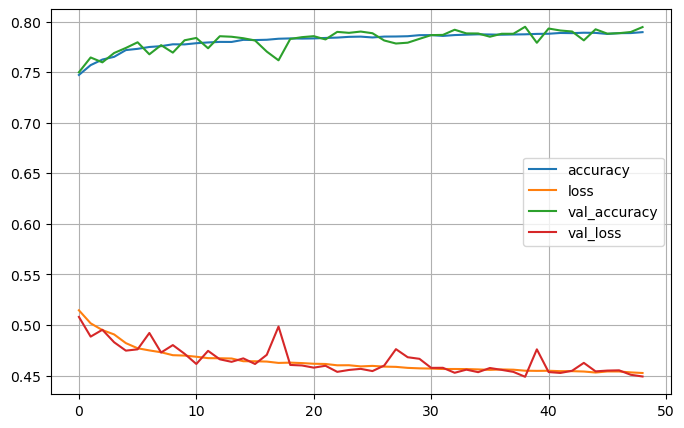

In [12]:
utilities.plot_hist_trainning(history)